In [ ]:
# | default_exp schedulers/noise

# Imports

In [ ]:
# | export


import torch
from torch import nn

# Schedulers

In [ ]:
# | export


class NoiseScheduler(nn.Module):
    """Base class for Gussian noise schedulers used in diffusion models"""

    def __init__(self, betas: torch.Tensor | None = None, alphas_cumprod: torch.Tensor | None = None):
        super().__init__()

        assert (betas is None) != (alphas_cumprod is None), "Either betas or alphas_cumprod should be provided"

        if betas is not None:
            alphas = 1.0 - betas
            alphas_cumprod = torch.cumprod(alphas, dim=0)
            sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
            sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        elif alphas_cumprod is not None:
            alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
            betas = 1.0 - alphas
            sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
            sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        else:
            raise NotImplementedError

        self.T = len(betas) - 1  # The first element is assumed not to be used i.e. t=0 is unused

        betas[0] = 0.0
        alphas[0] = 1.0
        alphas_cumprod[0] = 1.0
        sqrt_alphas_cumprod[0] = 1.0
        sqrt_one_minus_alphas_cumprod[0] = 0.0

        # Register as non-persistent buffers so that they are moved to the correct device
        self.register_buffer("betas", betas, persistent=False)
        self.register_buffer("alphas", alphas, persistent=False)
        self.register_buffer("alphas_cumprod", alphas_cumprod, persistent=False)
        self.register_buffer("sqrt_alphas_cumprod", sqrt_alphas_cumprod, persistent=False)
        self.register_buffer("sqrt_one_minus_alphas_cumprod", sqrt_one_minus_alphas_cumprod, persistent=False)

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor | None = None):
        """If noise is not provided, it is sampled from a standard normal distribution"""

        # x0: (b, ...)
        # t: (b,)
        # noise: (b, ...)

        assert (t <= self.T).all(), "t should be less than T"

        t.clamp_(min=0)

        noise_provided: bool = True
        if noise is None:
            noise_provided = False
            noise = torch.randn_like(x0)

        unsqueeze = [slice(0, None)] + [None] * (len(x0.shape) - 1)
        xt = self.sqrt_alphas_cumprod[t][unsqueeze] * x0 + self.sqrt_one_minus_alphas_cumprod[t][unsqueeze] * noise

        if not noise_provided:
            return xt, noise
        return xt

    def remove_noise(self, xt: torch.Tensor, noise_pred: torch.Tensor, t: torch.Tensor):
        # xt: (b, ...)
        # noise_pred: (b, ...)
        # t: (b,)

        assert (0 < t).all() and (t <= self.T).all(), "t should be between (0, T]"

        unsqueeze = [slice(0, None)] + [None] * (len(xt.shape) - 1)

        x0_hat = (xt - (self.sqrt_one_minus_alphas_cumprod[t][unsqueeze] * noise_pred)) / self.sqrt_alphas_cumprod[t][
            unsqueeze
        ]

        mean_batch = xt - (
            (self.betas[t][unsqueeze] * noise_pred) / (self.sqrt_one_minus_alphas_cumprod[t][unsqueeze])
        ) / torch.sqrt(self.alphas[t][unsqueeze])
        variance_batch = (
            self.betas[t][unsqueeze]
            * (1.0 - self.alphas_cumprod[t - 1][unsqueeze])
            / (1.0 - self.alphas_cumprod[t][unsqueeze])
        )
        sigma_batch = torch.sqrt(variance_batch)
        standard_noise = torch.randn_like(xt)

        xt_minus_1_hat = mean_batch + sigma_batch * standard_noise

        return x0_hat, xt_minus_1_hat

In [ ]:
T = 200
betas = torch.linspace(0.0001, 0.02, T)
scheduler = NoiseScheduler(betas)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class LinearNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2006.11239
    def __init__(self, T: int, min_beta: float = 0.0001, max_beta: float = 0.02):
        betas = torch.linspace(min_beta, max_beta, T)
        super().__init__(betas)

In [ ]:
T = 200
scheduler = LinearNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class CosineNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2102.09672
    def __init__(self, T: int, s: float = 0.008, min_alphas_cumprod: float = 1e-9):
        self.s = s

        alphas_cumprod = torch.cos(((torch.arange(T) / T + s) / (1 + s)) * (torch.pi / 2)) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas_cumprod.clamp_(min=min_alphas_cumprod)
        super().__init__(alphas_cumprod=alphas_cumprod)

In [ ]:
T = 200
scheduler = CosineNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class SigmoidNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2212.11972
    def __init__(
        self, T: int, tau: float = 1.0, sigmoid_start: int = -3, sigmoid_end: int = 3, min_alphas_cumprod: float = 1e-9
    ):
        self.tau = tau
        self.sigmoid_start = sigmoid_start
        self.sigmoid_end = sigmoid_end

        start = torch.tensor(sigmoid_start)
        end = torch.tensor(sigmoid_end)
        v_start = torch.sigmoid(start / tau)
        v_end = torch.sigmoid(end / tau)

        alphas_cumprod = (-torch.sigmoid(((torch.arange(T) / T) * (end - start) + start) / tau) + v_end) / (
            v_end - v_start
        )
        alphas_cumprod.clamp_(min=min_alphas_cumprod)
        super().__init__(alphas_cumprod=alphas_cumprod)

In [ ]:
T = 200
scheduler = SigmoidNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class FibonacciNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2009.00713
    def __init__(self, T: int, first_element: float = 1e-6, second_element: float = 2e-6):
        assert T > 2, "T should be greater than 2"
        if T > 25:
            print("Warning: This noise scheduler explodes very quickly. Be careful with large T values.")
        betas = [first_element, second_element]
        for _ in range(2, T):
            betas.append(betas[-1] + betas[-2])
        betas = torch.Tensor(betas).clamp(0.0, 1.0)
        super().__init__(betas=betas)

In [ ]:
T = 30
scheduler = FibonacciNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class ExponentialNoiseScheduler(NoiseScheduler):
    def __init__(self, T: int, beta_min: float = 0.0001, beta_max: float = 0.02):
        self.beta_min = beta_min
        self.beta_max = beta_max

        betas = beta_min * (beta_max / beta_min) ** ((torch.arange(T) - 1) / (T - 1))
        super().__init__(betas=betas)

In [ ]:
T = 30
scheduler = ExponentialNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

In [ ]:
# | export


class SquareRootNoiseScheduler(NoiseScheduler):
    # https://arxiv.org/pdf/2205.14217
    def __init__(self, T: int, s: float = 0.008, min_alphas_cumprod: float = 1e-9):
        self.s = s

        alphas_cumprod = 1 - torch.sqrt(torch.arange(T) / T + s)
        alphas_cumprod.clamp_(min=min_alphas_cumprod)
        super().__init__(alphas_cumprod=alphas_cumprod)

In [ ]:
T = 30
scheduler = SquareRootNoiseScheduler(T)

x0 = torch.zeros(2, 3, 32, 32)
t = torch.tensor([1, 10])
xt, noise = scheduler.add_noise(x0, t)

x0_hat, xt_minus_1 = scheduler.remove_noise(xt, noise, t)
assert torch.allclose(x0_hat, x0)

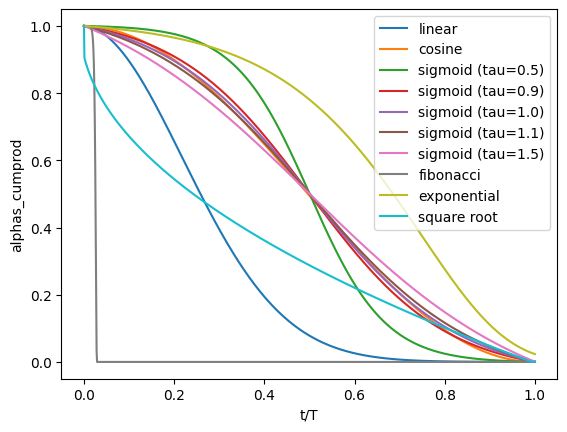

In [ ]:
from matplotlib import pyplot as plt

T = 1000
alphas_cumprods = {
    "linear": LinearNoiseScheduler(T).alphas_cumprod,
    "cosine": CosineNoiseScheduler(T).alphas_cumprod,
    "sigmoid (tau=0.5)": SigmoidNoiseScheduler(T, 0.5).alphas_cumprod,
    "sigmoid (tau=0.9)": SigmoidNoiseScheduler(T, 0.9).alphas_cumprod,
    "sigmoid (tau=1.0)": SigmoidNoiseScheduler(T).alphas_cumprod,
    "sigmoid (tau=1.1)": SigmoidNoiseScheduler(T, 1.1).alphas_cumprod,
    "sigmoid (tau=1.5)": SigmoidNoiseScheduler(T, 1.5).alphas_cumprod,
    "fibonacci": FibonacciNoiseScheduler(T).alphas_cumprod,
    "exponential": ExponentialNoiseScheduler(T).alphas_cumprod,
    "square root": SquareRootNoiseScheduler(T).alphas_cumprod,
}

for key, value in alphas_cumprods.items():
    plt.plot(torch.linspace(0, 1, T), value, label=key)
plt.xlabel("t/T")
plt.ylabel("alphas_cumprod")
plt.legend()
plt.show()

# nbdev

In [ ]:
!nbdev_export